First of all we need all the necessary librarys to run this beauty!

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from random import randrange, shuffle
from os import path
import librosa
from librosa.display import specshow
import IPython.display as ipd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import time

Check to see if GPU is available

In [2]:
if (len(tf.config.experimental.list_physical_devices("GPU")) > 0):
    print("GPU is available!")
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.75)
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

GPU is available!


Open and read the csv with all the audio information

In [3]:
csvPath    = r"F:\labeled_audio_data.csv"
specPath   = r"F:\Labeled_Specs"
audioPath  = r"F:\Labeled_Audio"
modelPath  = r"F:\Models"
logPath    = r"F:\Logs"

version      = r"1.1" #When you make changes, update the version!!
creationTime = time.strftime("%d.%m.%H.%M.%S", time.localtime())

dataFrame = pd.read_csv(csvPath)
dataDictionary = dataFrame.to_dict()
print(dataDictionary.keys())

dict_keys(['Unnamed: 0', 'filename', 'mainSound', 'length', 'sampleRate', 'quality', 'isCut', 'isMixed', 'isChecked', 'threat', 'salience', 'importance'])


Now just use a snippet of the data for now,
This is to be RAM friendly and for testing purposes.
The Training and Test Data will be a list containing a list that looks like the following:
(filename, mainsound, spectrogram, threat, salience, importance)
filename is a string of the filename
mainsound is a string of the sound category
Spectrogram holds a numpy array of the log spectrogram
threat, salience and importance are single numbers and the output values

In [4]:
numAudiosPerBatch = 2000 #Number of audiofiles to train with per Batch

allFileNames = list(dataDictionary['filename'].values())
#allMainSound = list(dataDictionary['mainSound'].values())
#allThreat = list(dataDictionary['threat'].values())
#allSalience = list(dataDictionary['salience'].values())
#allImportance = list(dataDictionary['importance'].values())

training_data = []

dataIndex = 0
numBatches   = int(len(allFileNames) / numAudiosPerBatch)
testDataSize = len(allFileNames) % numAudiosPerBatch
print("TrainBatches:", numBatches, ", Testdata:", testDataSize)

ids = list(range(0, len(allFileNames)))
shuffle(ids) #, int(time.strftime("%S", time.localtime()))/60

def createTrainingData():
    #ID list ro iterate through all the data
    global dataIndex
    print("Get new training data: ", int(dataIndex/numAudiosPerBatch), "/", (numBatches-1), sep = "")
    for i in range(numAudiosPerBatch):
        perc = int( 20 * i / numAudiosPerBatch)
        bar = "[" + "=" * (perc) + ">" + "-" * (19-perc) + "]"
        print(bar, end="\r")
        audioFile = ids[i+dataIndex]
        filename = allFileNames[audioFile]
        #Load the spectrogram
        try:
            specFilePath = path.join(specPath, (filename+".npz"))
            spectrogramNP = np.load(specFilePath)
            spectrogram = spectrogramNP[spectrogramNP.files[0]]
            spectrogram = spectrogram[0]
            #Load the target values
            mainSound  = list(dataDictionary['mainSound'].values())[audioFile]
            threat     = list(dataDictionary['threat'].values())[audioFile]      / 10 #Bring the data from 0-9 to 0.0 - 0.9
            salience   = list(dataDictionary['salience'].values())[audioFile]    / 10
            importance = list(dataDictionary['importance'].values())[audioFile]  / 10
        
            training_data.append([filename, mainSound, spectrogram, threat, salience, importance])
        except:
            pass
    dataIndex += numAudiosPerBatch
    print()
    print("Done!")

test_data = []

def createTestData():
    for i in range(len(allFileNames)-testDataSize, len(allFileNames)):
        audioFile = ids[i]
        filename = allFileNames[audioFile]
        #Load the spectrogram
        try:
            specFilePath = path.join(specPath, (filename+".npz"))
            spectrogramNP = np.load(specFilePath)
            spectrogram = spectrogramNP[spectrogramNP.files[0]]
            spectrogram = spectrogram[0]
            #Load the target values
            mainSound  = list(dataDictionary['mainSound'].values())[audioFile]
            threat     = list(dataDictionary['threat'].values())[audioFile]      / 10 #Bring the data from 0-9 to 0.0 - 0.9
            salience   = list(dataDictionary['salience'].values())[audioFile]    / 10
            importance = list(dataDictionary['importance'].values())[audioFile]  / 10
        
            test_data.append([filename, mainSound, spectrogram, threat, salience, importance])
        except:
            pass

createTrainingData()
createTestData()
spec_width  = len(training_data[0][2])
spec_height = len(training_data[0][2][0])
#print(spec_width, spec_height, sep="|") #spectrogram size:

#del allMainSound, allThreat, allSalience, allImportance, ids

TrainBatches: 4 , Testdata: 331
Get new training data: 0/3
[===================>]
Done!


Lets plot a random spectrogram!

1-17742-A-12  :  fire


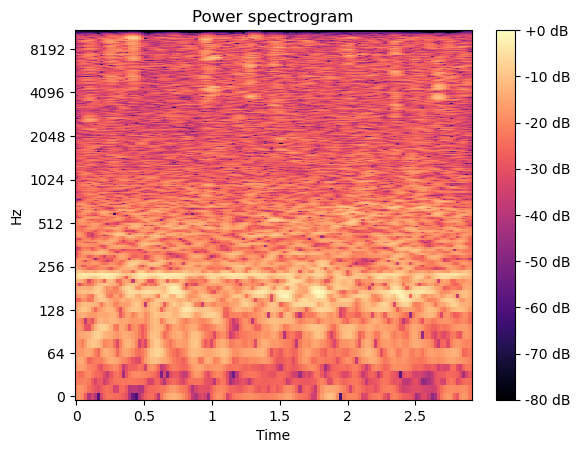

In [5]:
audioToPick = randrange(0,len(training_data),1)
print(training_data[audioToPick][0], " : ",  training_data[audioToPick][1])
#plt.imshow(training_data[audioToPick][2], cmap="plasma", aspect="auto")
fig, ax = plt.subplots()
img = specshow(training_data[audioToPick][2], y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
ipd.Audio(path.join(audioPath, (training_data[audioToPick][0]+".wav")))

Lets describe the dataset:

In [6]:
print("Number of audiofiles:", len(training_data))
print("Lets get the percentage of each Class:")
categorys = set(dataDictionary['mainSound'].values())
trainingDataCategorys = [data[1] for data in training_data] 
for key in categorys:
    print("Key:", key.ljust(17, " "), ", perc.:", round(trainingDataCategorys.count(key)/len(training_data), 3))
    
del categorys, trainingDataCategorys

Number of audiofiles: 1943
Lets get the percentage of each Class:
Key: exterior          , perc.: 0.366
Key: emergency_vehicle , perc.: 0.001
Key: explosion         , perc.: 0.005
Key: car_horn          , perc.: 0.036
Key: screaming         , perc.: 0.003
Key: interior          , perc.: 0.107
Key: animal            , perc.: 0.129
Key: gunshot           , perc.: 0.036
Key: siren             , perc.: 0.141
Key: bicycle_bell      , perc.: 0.002
Key: human             , perc.: 0.114
Key: clock_alarm       , perc.: 0.004
Key: fire              , perc.: 0.006
Key: fireworks         , perc.: 0.005
Key: crying_baby       , perc.: 0.006
Key: natural           , perc.: 0.041


In [7]:
train_x=[]
train_y=[]
def sortTrainingData():
    global train_x, train_y
    train_x = [data[2] for data in training_data]
    train_y = [[data[3], data[4], data[5]] for data in training_data]
    train_x = np.array(train_x).reshape(-1, spec_width, spec_height, 1)
    train_y = np.array(train_y)

sortTrainingData()

Now the really fun part!
Create a Convolutional network that can get the spectrograms as input data and spits out its output data!

In [8]:
model = keras.models.Sequential([
    #Input layer
    keras.layers.Conv2D(64, (3,3), strides=(1,1), padding="valid", activation="relu", input_shape=train_x.shape[1:]),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    #...repeat until happy...
    
    #Flatten layer: make 1D out of 2D
    #keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Flatten(),
    
    #Hidden layer(s) 
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    
    #output layer
    keras.layers.Dense(3, activation = 'sigmoid'),
])

modelName = "2Conv3Dense-{}-".format(creationTime) + version
print("Name:", modelName)
print(model.summary())

tensorboard = tf.keras.callbacks.TensorBoard(path.join(logPath, modelName), histogram_freq=1)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Name: 2Conv3Dense-11.03.15.01.25-1.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1023, 124, 64)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 511, 62, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 509, 60, 32)       18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 30, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 243840)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31211648  
_________________________________________________________________
dense_1 (Dense)    

Now lets get the first training session done!

In [9]:
histories = []
for batch in range((numBatches-1):
    try:
        histories.append(model.fit(train_x, train_y, batch_size=20, validation_split=0.1, epochs=5, callbacks=[tensorboard]))
    except:
        pass
    training_data = []
    createTrainingData()
    sortTrainingData()


Epoch 1/5
88/88 [==============================] - 11s 67ms/step - loss: 1.6971 - accuracy: 0.9039 - val_loss: 0.5993 - val_accuracy: 0.9128
Epoch 2/5
88/88 [==============================] - 5s 57ms/step - loss: 0.6005 - accuracy: 0.9411 - val_loss: 0.5923 - val_accuracy: 0.9128
Epoch 3/5
88/88 [==============================] - 5s 57ms/step - loss: 0.5880 - accuracy: 0.9382 - val_loss: 0.5866 - val_accuracy: 0.9128
Epoch 4/5
88/88 [==============================] - 5s 57ms/step - loss: 0.5805 - accuracy: 0.9308 - val_loss: 0.5859 - val_accuracy: 0.9128
Epoch 5/5
88/88 [==============================] - 5s 57ms/step - loss: 0.5501 - accuracy: 0.9182 - val_loss: 0.5900 - val_accuracy: 0.9179
Get new training data: 1/3
[===================>]
Done!
Epoch 1/5
88/88 [==============================] - 6s 66ms/step - loss: 0.6033 - accuracy: 0.9377 - val_loss: 0.5903 - val_accuracy: 0.9231
Epoch 2/5
88/88 [==============================] - 5s 57ms/step - loss: 0.5755 - accuracy: 0.9326 - val

IndexError: list index out of range

Lets let the model predict some data!

In [10]:
i = randrange(dataIndex, len(allFileNames), 1)
audioFile = ids[i]
filename = allFileNames[audioFile]
specFilePath = path.join(specPath, (filename+".npz"))
spectrogramNP = np.load(specFilePath)
spectrogram = spectrogramNP[spectrogramNP.files[0]]
spectrogram = spectrogram[0]
test_x = np.array(spectrogram).reshape(-1, spec_width, spec_height, 1)
test_y = np.array([list(dataDictionary['threat'].values())[ids[i]], list(dataDictionary['salience'].values())[ids[i]], list(dataDictionary['importance'].values())[ids[i]]])
print("Infos: ", end="")
print( filename, list(dataDictionary['mainSound'].values())[ids[i]], sep=" | ")
#print(path.join(audioPath, (filename+".wav")))
print("Goal:  ", test_y / 10)
prediction = model(test_x)
print("Result: ", end="")
print(prediction.numpy()[0])
ipd.Audio(path.join(audioPath, (filename+".wav")))

Infos: 62837-7-1-45 | exterior
Goal:   [0.2 0.8 0. ]
Result: [0.10862865 0.676365   0.00387362]


Create a Confusion Matrix:

In [12]:
training_data = test_data[:]
sortTrainingData()
predict_y = model.predict(train_x)
mat = confusion_matrix(train_y, predict_y)
plot_confusion_matrix(conf_mat=mat, figsize=(10,10))

ValueError: continuous-multioutput is not supported

Last but not least, lets save the model.

In [14]:
model.save(path.join(modelPath, modelName))

INFO:tensorflow:Assets written to: F:\Models\2Conv3Dense-11.03.15.01.25-1.1\assets
